In [1]:
import ligo.skymap.plot
import cosmoplotian.colormaps
import numpy as np
import healpy as hp
import h5py
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import requests
import chivos.plaszczynski
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data

## Download information

Data downloaded from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/P41KDE

Corresponds to:

`{X}_v_HI4PI_Kkms.h5` : with $X \in I,~Q,~U$. HI estimate of Stokes parameters by velocity bin.
`HI4PI_startvels.npy`, `HI4PI_stopvels.npy` : boundaries of the velocity bins for the above files

`IQU_integrated_HI4PI_Kkms.fits` : HI-estimated Stokes I, Q, U summed over velocity bins.

`HFI_SkyMap_353-psb_2048_R3.01_full.fits` : PR3 Planck 353 GHz full mission Stokes I, Q, U.

`COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits` : Planck single-resolution T, Q, U product dust emission at downloaded from:  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits

In [ ]:
root = Path(os.environ["SCRATCH"]) / "h1"
root.mkdir(exist_ok=True)

downloads = [
    ("IQU_integrated_HI4PI_Kkms.fits", 
     "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/P41KDE/DLAMEB"
    ),
    ("I_v_HI4PI_Kkms.h5",
     "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/P41KDE/KT7PV4"
    ),
    ("Q_v_HI4PI_Kkms.h5",
     "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/P41KDE/AMYVEG"
    ),
    ("U_v_HI4PI_Kkms.h5",
     "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/P41KDE/ZCRY3D"
    ),
    ("HI4PI_startvels.npy",
     "https://github.com/seclark/ClarkHensley2019/raw/master/data/HI4PI_startvels.npy"
    ),
    ("HI4PI_stopvels.npy",
     "https://github.com/seclark/ClarkHensley2019/raw/master/data/HI4PI_stopvels.npy"
    ),
    ("COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits",
     "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits"
    )
]

for fname, url in downloads:
    save_path = root / fname
    if save_path.exists():
        print(f"File {save_path} already exists, not downloading.")
        continue
    else:
        print(f"Downloading to {save_path}.")
        req = requests.get(url, stream=True, allow_redirects=True)
        with open(save_path, 'wb') as f:
            for chunk in req.iter_content(8096):
                if chunk:
                    f.write(chunk)

# for convenience store local paths to data files in dictionary
data_paths = {fname: str(root / fname) for fname, _ in downloads}
                            
display(data_paths)

In [ ]:
print(data_paths)

# T, Q, U maps summed over velocity bins
IQU_fn = root / "IQU_integrated_HI4PI_Kkms.fits"

# T, Q, U maps split by velocity bin
I_v_fn = root / "I_v_HI4PI_Kkms.h5"
Q_v_fn = root / "Q_v_HI4PI_Kkms.h5"
U_v_fn = root / "U_v_HI4PI_Kkms.h5"

# Beginning and end of velocity bins
nu_ini_fn = root / "HI4PI_startvels.npy"
nu_end_fn = root / "HI4PI_stopvels.npy"


# Planck products 
#planck_353_fn = root / "HFI_SkyMap_353-psb_2048_R3.01_full.fits" # 353 GHz data
planck_353_fn = root / "COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits" # 353 GHz GNILC separated maps

## Planck map preprocessing

In order to correct for the CIB monopole at 353 GHz and a Galactic offset correction, we first subtract 452 $\mu~K_{\rm CMB}$ and then add 63 $\mu~K_{\rm CMB}$ to the Stokes $I$ map. 

HI4PI data has some `nan` values, which we set to zero for now.

In [56]:
HDU_HI4PI = fits.open(data_paths['IQU_integrated_HI4PI_Kkms.fits'])
display(HDU_HI4PI[1].header)

HDU_GNILC = fits.open(data_paths['COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits'])
display(HDU_GNILC[1].header)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   12 / length of dimension 1                          
NAXIS2  =             12582912 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'IHI     '                                                            
TFORM1  = 'E       '                                                            
TUNIT1  = 'K km/s  '                                                            
TTYPE2  = 'QHI     '                                                            
TFORM2  = 'E       '        

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   36 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    9 / number of fields in each row                   
COMMENT  -------------------------------------------------------------          
COMMENT  Products from GNILC component separation method                        
COMMENT  -------------------------------------------------------------          
COMMENT  Further details in the Planck Legacy Archive and Explanatory Supplement
COMMENT  http://www.cosmos.e

In [57]:
nside = 256
# convert to uK and apply CMB monopole correction and Galactic offset correction
I_GNILC = hp.reorder(HDU_GNILC[1].data['I_STOKES'] * 1e6 - 452. + 63., 'NESTED', 'RING')
Q_GNILC = hp.reorder(HDU_GNILC[1].data['Q_STOKES'] * 1e6, 'NESTED', 'RING')
U_GNILC = hp.reorder(HDU_GNILC[1].data['U_STOKES'] * 1e6, 'NESTED', 'RING')

In [58]:
IQU_GNILC = hp.ud_grade((I_GNILC, Q_GNILC, U_GNILC), nside_out=nside)
ALMS_GNILC = hp.map2alm(IQU_GNILC)

Read HI data in. This contains some `NaN` pixels, so for now set these to zero as they are not well accounted for by the various smoothing operations to follow.

In [59]:
I_HI4PI = np.nan_to_num(HDU_HI4PI[1].data['IHI'])
Q_HI4PI = np.nan_to_num(HDU_HI4PI[1].data['QHI'])
U_HI4PI = np.nan_to_num(HDU_HI4PI[1].data['UHI'])

In [60]:
IQU_HI4PI = hp.ud_grade((I_HI4PI, Q_HI4PI, U_HI4PI), nside_out=nside)
ALMS_HI4PI = hp.map2alm(IQU_HI4PI)

## Filtering maps to same resolution

The native resolutions of the Planck and HI estimated maps are different, $4.9^\prime$ and $16.2^\prime$, respectively. Deconvolve the beams, and reconvolve to a common resolution of $80^\prime$, for which the S/N in the Planck maps is suitably high for analysis.

*N.B. This is no longer necessary - the GNILC single-resolution maps are apparently already smoothed to $80^\prime$.*

In [61]:
# FWHM specifications in arcminutes
FWHM = 80. # arcmins
FWHM_GNILC = 80. # arcmins
FWHM_HI4PI = 16.2 # arcmins

# set lmax by hand for the calculation of the beam profiles to be correct
lmax = 3 * nside - 1

In [62]:
# calculate the functions of ell by which to multiple each map's alms.
GAUSS_DECON_HI4PI = 1. / hp.gauss_beam(np.radians(FWHM_HI4PI / 60.), lmax)
GAUSS_BEAM_80AMIN = hp.gauss_beam(np.radians(FWHM / 60.), lmax)

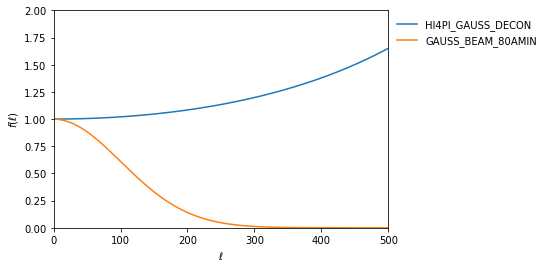

In [63]:
fig, ax = plt.subplots(1, 1)
ax.plot(GAUSS_DECON_HI4PI, label='HI4PI_GAUSS_DECON')
ax.plot(GAUSS_BEAM_80AMIN, label='GAUSS_BEAM_80AMIN')
ax.set_xlim(0, 500)
ax.set_ylim(0, 2)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$f(\ell)$")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
fig.savefig('plots/filter_functions.png', bbox_inches='tight')

Calculate $a_{\ell m}$'s and deconvolve / reconvolve

In [64]:
ALMS_80AMIN_HI4PI = [hp.almxfl(alms, GAUSS_BEAM_80AMIN * GAUSS_DECON_HI4PI) for alms in ALMS_HI4PI]
IQU_80AMIN_HI4PI = hp.alm2map(ALMS_80AMIN_HI4PI, nside, verbose=False)

## Derived quantities for plotting

These are the derived quantities with a degree scale smoothing for plotting comparison purposes. We'll recompute them with a higher resolution beam later on.

### Polarization quantities

$$
\theta = \frac{1}{2}\tan^{-1}(U / Q)
$$

$$
P = \sqrt{Q^2 + U^2}
$$

$$
p = P / I
$$

In [65]:
def polarization_angle(Q, U):
    return np.mod(0.5 * np.arctan2(- U, Q), np.pi)

def polarization_intensity(Q, U):
    return np.sqrt(Q ** 2 + U ** 2)

def polarization_fraction(I, Q, U):
    return polarization_intensity(Q, U) / I

def polarization_quantities(iqu_arr):
    return (polarization_angle(iqu_arr[1], iqu_arr[2]), 
            polarization_intensity(iqu_arr[1], iqu_arr[2]), 
            polarization_fraction(iqu_arr[0], iqu_arr[1], iqu_arr[2]))

In [66]:
# polarization angle
POL_ANGLE_HI4PI_80AMIN, POL_INT_HI4PI_80AMIN, POL_FRAC_HI4PI_80AMIN = polarization_quantities(IQU_80AMIN_HI4PI)
POL_ANGLE_GNILC, POL_INT_GNILC, POL_FRAC_GNILC = polarization_quantities(IQU_GNILC)

## Clark / Hensley 2019 Fig 8

 Now we reproduce the plots in Clark et al 2019 Figure 8 to check the maps.

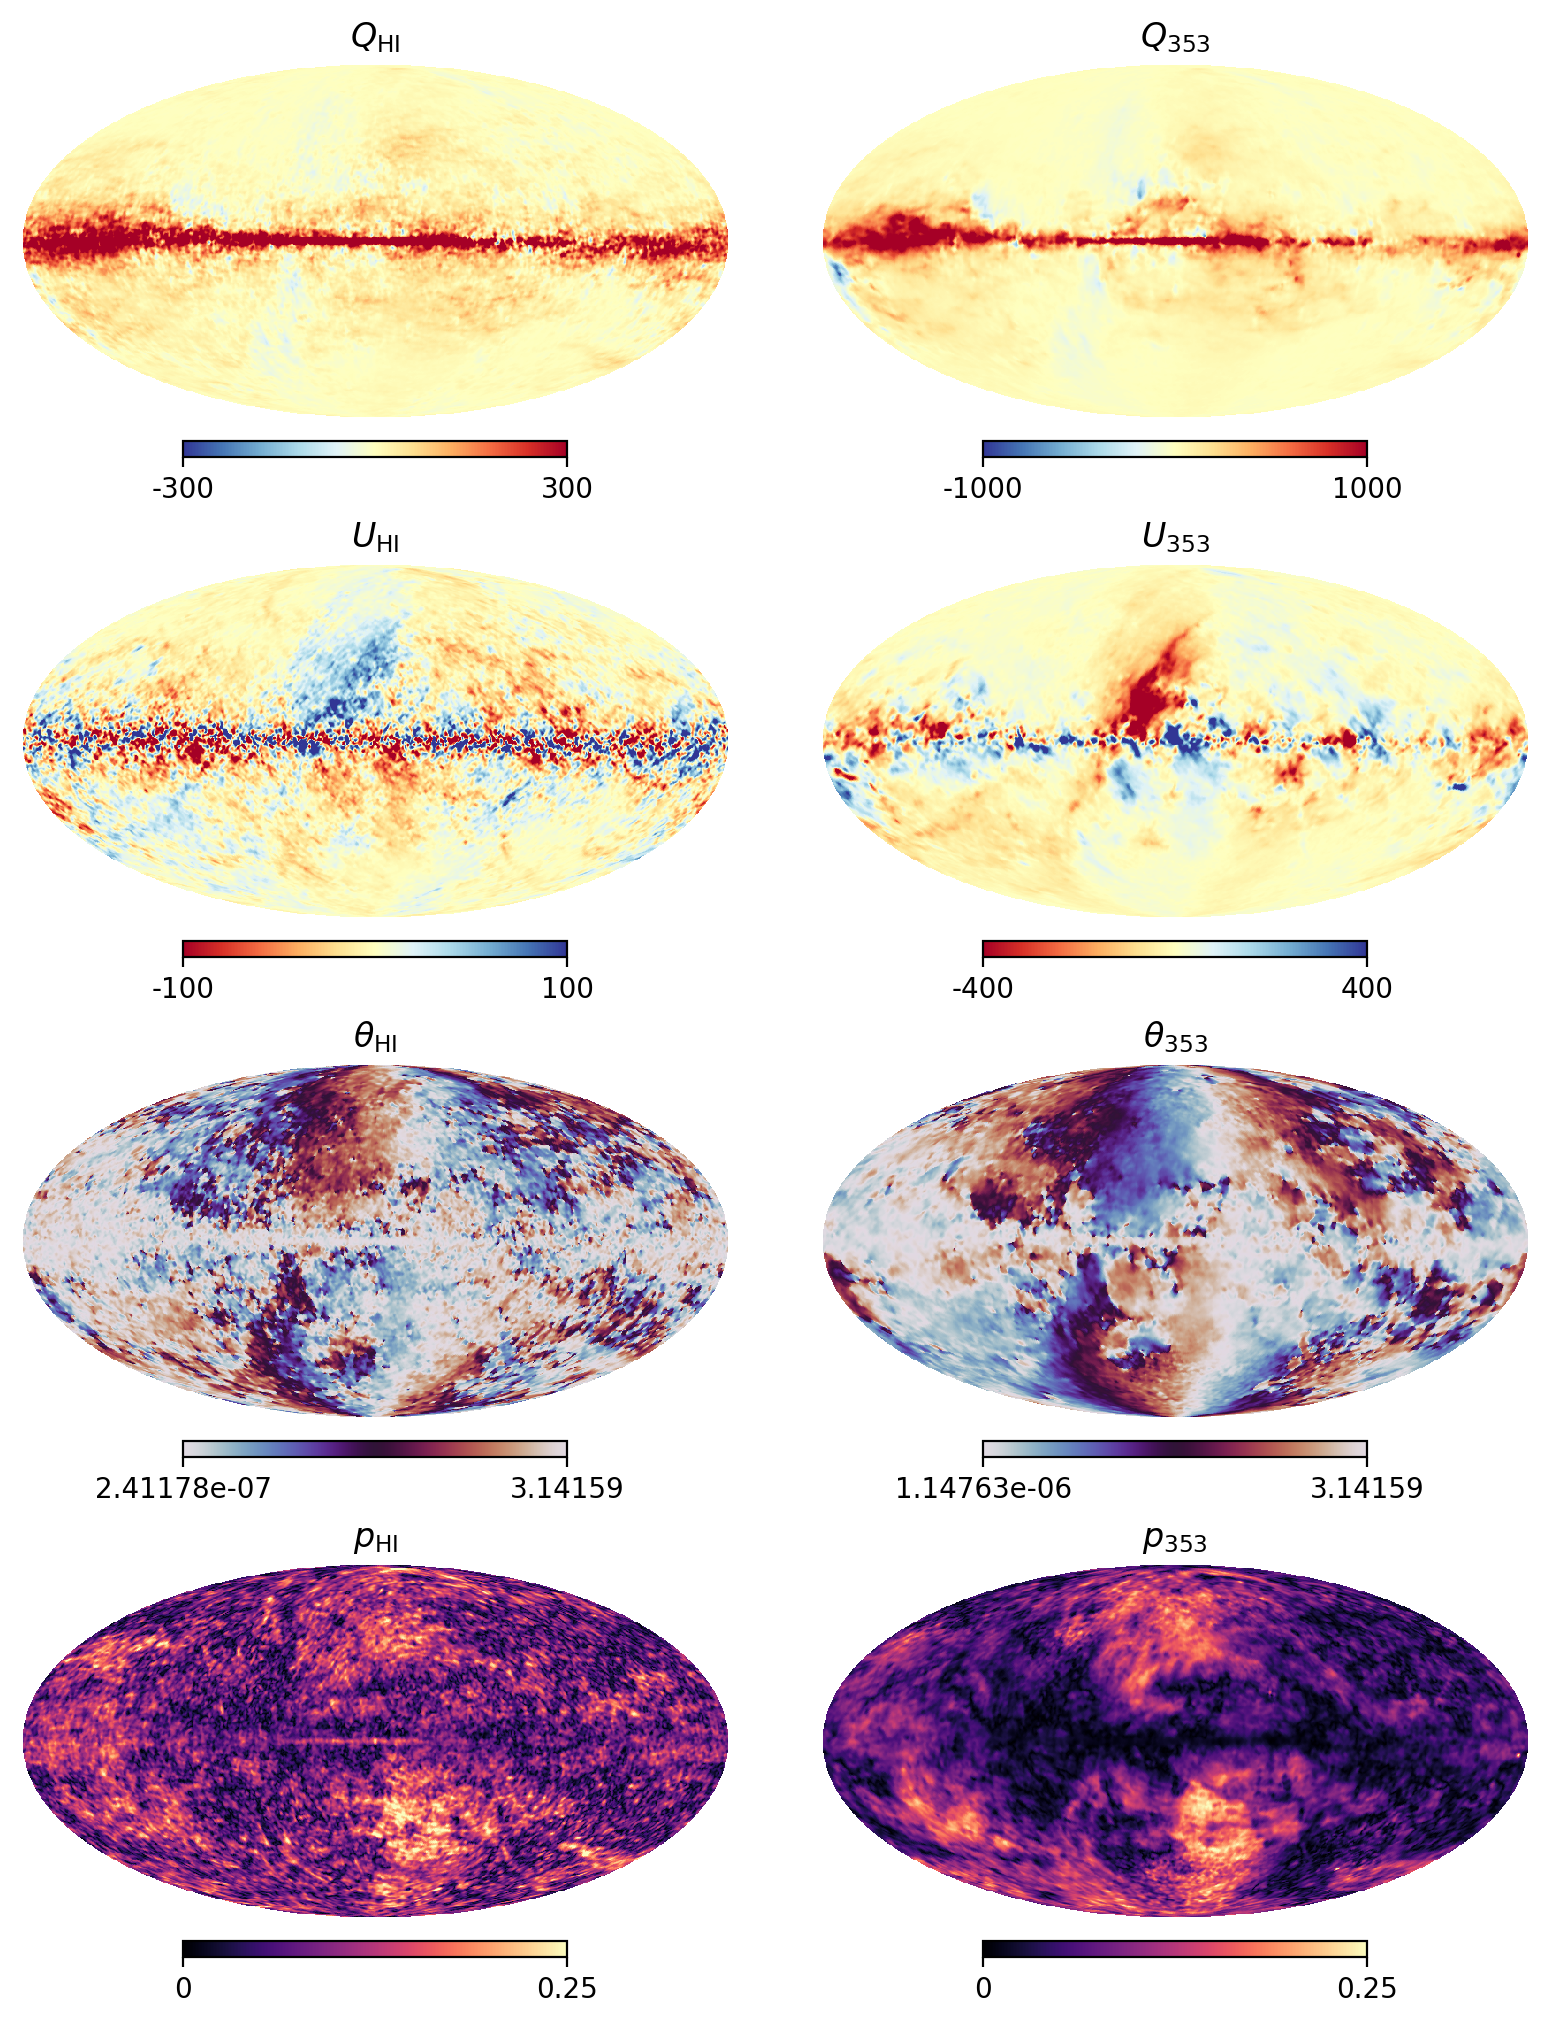

In [67]:
fig = plt.figure(figsize=(8, 10), dpi=200)

# plot Q
hp.mollview(IQU_80AMIN_HI4PI[1], sub=421, title=r"$Q_{\rm HI}$", min=-300, max=300, cmap='RdYlBu_r')
hp.mollview(IQU_GNILC[1], sub=422, title=r"$Q_{\rm 353}$", min=-1000, max=1000, cmap='RdYlBu_r')

# plot U
hp.mollview(IQU_80AMIN_HI4PI[2], sub=423, title=r"$U_{\rm HI}$", min=-100, max=100, cmap='RdYlBu')
hp.mollview(IQU_GNILC[2], sub=424, title=r"$U_{\rm 353}$", min=-400, max=400, cmap='RdYlBu')

# plot theta
hp.mollview(POL_ANGLE_HI4PI_80AMIN, sub=425, title=r"$\theta_{\rm HI}$", min=None, max=None, cmap='twilight')
hp.mollview(POL_ANGLE_GNILC, sub=426, title=r"$\theta_{\rm 353}$", min=None, max=None, cmap='twilight')

# plot p
hp.mollview(POL_FRAC_HI4PI_80AMIN, sub=427, title=r"$p_{\rm HI}$", min=0., max=0.25, cmap='magma')
hp.mollview(POL_FRAC_GNILC, sub=428, title=r"$p_{\rm 353}$", min=0., max=0.25, cmap='magma')

fig.savefig('plots/clark_2019_fig8.png', bbox_inches='tight')

##  Plaszczynski+'14 Estimator, $P_{\rm MAS}$

In order to evaluate the polarization fraction at a resolution different to the input GNILC maps, we have to do some extra work. 

### Debiasing 

Firstly, the polarized intensity is a quadratic function of the Stokes parameters:

$$
P = \sqrt{Q^2 + U^2}.
$$

Therefore, the noise in the Stokes maps will constitute an additive bias.

There are measures one can take to mitigate this bias, but they require an estimate of the uncertainty in each pixel of the $P$ map. This would be fine if we were using the maximum resolution, however we are smoothing to ~$80^\prime$. This scale is chosen as it is the resolution required to have a $>3-\sigma$ detection of $P$ over the whole sky.

#### Plaszczynski+2014 estiamtor

A set of $Q,~U$ Stokes parameters within a pixel has uncertainties given by:

Given a pixel with an estimate of $Q$ and $U$, with covariance matrix given by:

$$
\mathsf{C} = \begin{pmatrix} \sigma_q^2 & \rho\sigma_q \sigma_u \\
                              \rho \sigma_q \sigma_u & \sigma_u^2 \end{pmatrix}
$$

In the presence of noise with this covariance, we can write down the estimator of Plaszczynski+'14:

$$
\phi_i = \arctan \frac{u_i}{q_i}
$$

$$
\theta = \frac{1}{2}\arctan \frac{2 \rho \sigma_q \sigma_u}{\sigma_q^2 - \sigma_u^2}
$$

$$
\sigma_q^{\prime 2} = \sigma_q^2 \cos^2\theta + \sigma_u^2 \sin^2 \theta + \rho \sigma_q \sigma_u \sin 2\theta
$$

$$
\sigma_u^{\prime 2} = \sigma_q^2 \sin^2\theta + \sigma_u^2 \cos^2 \theta - \rho \sigma_q \sigma_u \sin 2\theta
$$

$$
b_i^2 = \sigma_u^{\prime 2} \cos^2(\phi_i - \theta) + \sigma_q^{\prime 2}\sin^2(\phi_i - \theta)
$$

$$
\tilde{P} = P_i - b_i^2  \frac{1 - e^{- P_i^2 / b_i^2}}{2P_i}
$$

Check - here the subscript $i$ refers to individual pixels. Quantities that are derived from the noise covariance don't have this index, so the paper is assuming spatially uniform noise properties. Does this matter when implementing the estimator, so long as we are calculating $\theta$ per pixel?

### Smoothed covariance

[See for example](https://www.aanda.org/articles/aa/olm/2015/04/aa24082-14/aa24082-14.html)

When smoothing intensity maps, it is as simple as summing pixels multiplied by the Gaussian kernel you are applying. However, with $Q$ and $U$, one must also account for the small rotation of the reference axes between the two pixels being compared. This process is shown in Fig. A.1 of 1405.0871, and the relevant methods for both estimating the smoothed covariance and debiasing are in the accompanying text.

It is possible to compute the expected smoothed covariance by a careful rotation of the neighboring pixel's covariances, however, it is also possible, and much simpler to construct a Monte Carlo estimate of the transformed noise. As the process of smoothing is linear (being a sum over neighboring pixels, multiplied by a Gaussian-distributed weight) we expect the resulting uncertainty after smoothing to also be Gaussian.

The issue of smoothing covariance matrices is addressed further in [this notebook](covariance_smoothing.ipynb)

**N.B No longer need to worry about this as the GNILC templates are provided, with covariance matrixes, at the resolution we want to work at**.


In [23]:
COV_QQ_GNILC = HDU_GNILC[1].data['QQ_COV']
COV_UU_GNILC = HDU_GNILC[1].data['UU_COV']
COV_QU_GNILC = HDU_GNILC[1].data['QU_COV']

SIGMA_Q_GNILC = np.sqrt(COV_QQ_GNILC)
SIGMA_U_GNILC = np.sqrt(COV_UU_GNILC)

In [24]:
PMAS_GNILC = chivos.plaszczynski.PMAS(Q_GNILC, U_GNILC, SIGMA_Q_GNILC, SIGMA_U_GNILC, COV_QU_GNILC)
pmas_GNILC = PMAS_GNILC / I_GNILC

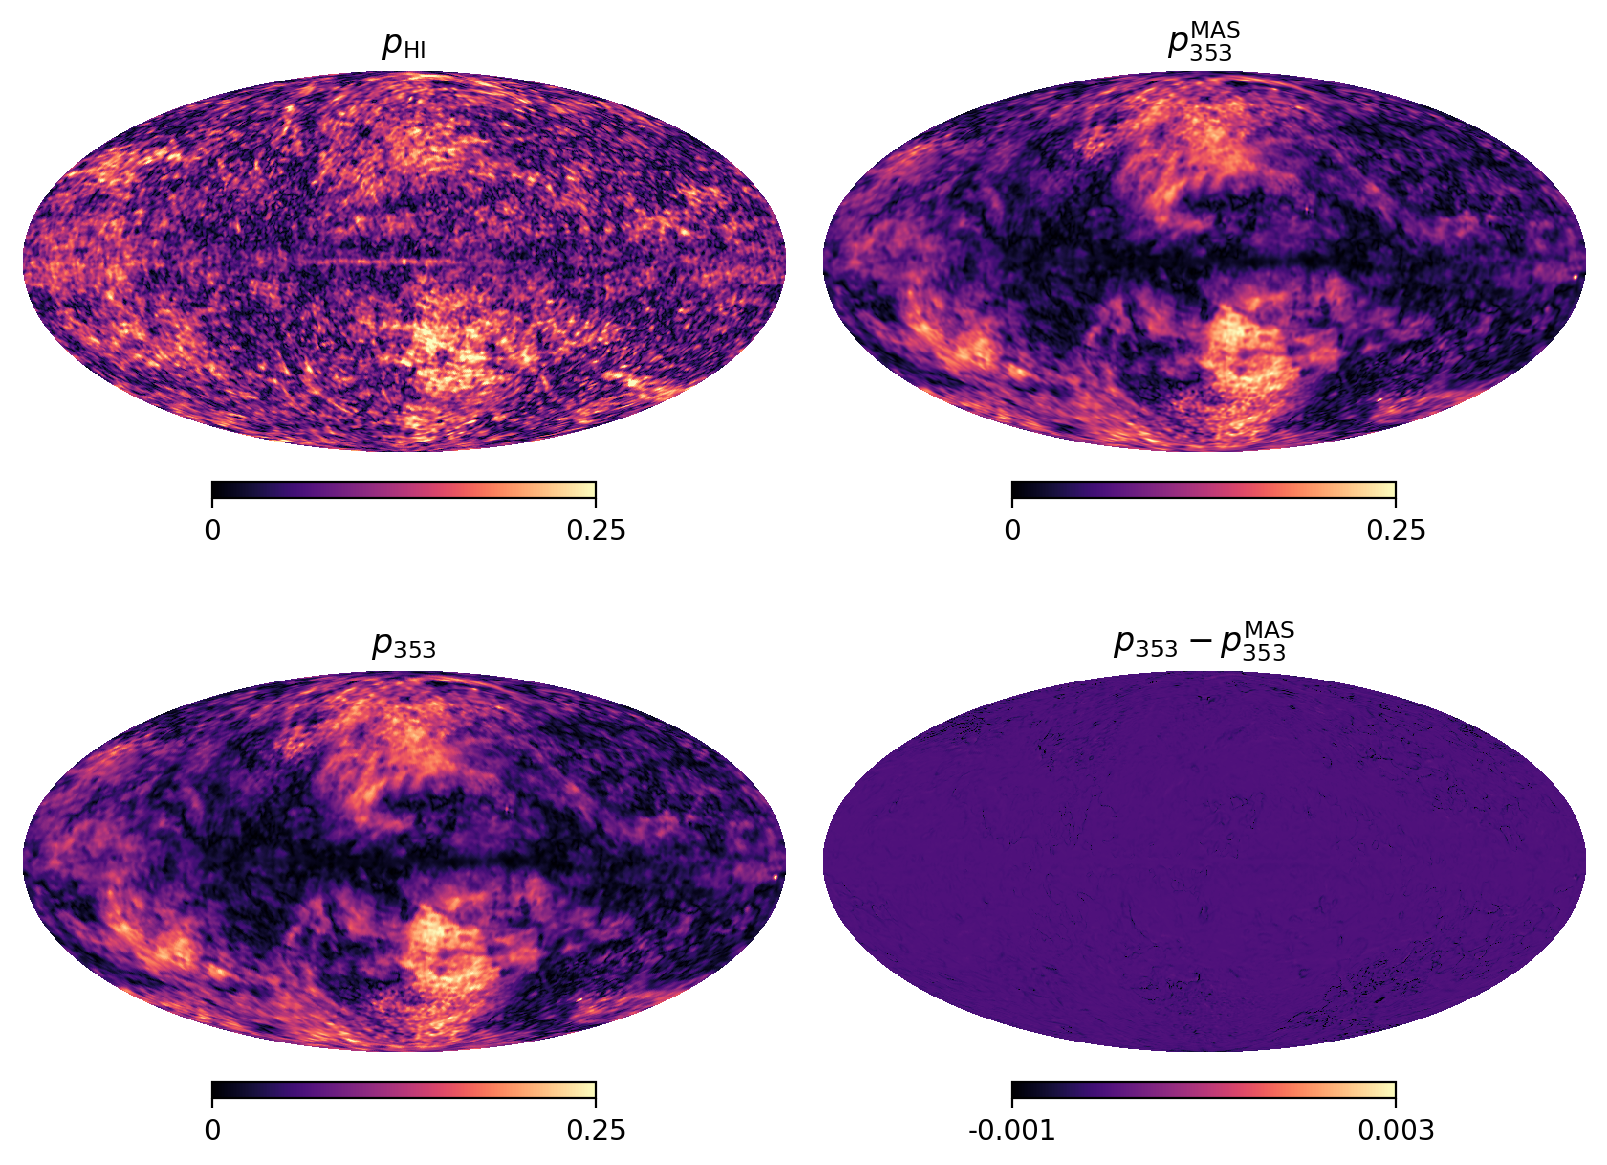

In [25]:
fig = plt.figure(figsize=(8, 6), dpi=200)
hp.mollview(POL_FRAC_HI4PI_80AMIN, sub=221, title=r"$p_{\rm HI}$", min=0., max=0.25, cmap='magma')
hp.mollview(pmas_GNILC, sub=222, title=r"$p^{\rm MAS}_{\rm 353}$", min=0., max=0.25, cmap='magma')
hp.mollview(POL_FRAC_GNILC, sub=223, title=r"$p_{\rm 353}$", min=0., max=0.25, cmap='magma')
hp.mollview(POL_FRAC_GNILC - hp.ud_grade(pmas_GNILC, nside_out=nside), sub=224, title=r"$p_{\rm 353} - p_{\rm 353}^{\rm MAS}$", min=-0.001, max=0.003, cmap='magma')
fig.savefig("plots/polarization_fraction_pMAS_pHI.png", bbox_inches='tight')

# Visualization on smaller scales

Let's check a region available to experiments at the South Pole. Zoom in on patch around RA=0, DEC=-60, which is the center of the BICEP observation region.

In [26]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic, ICRS

## Reproject maps to ICRS

In [27]:
# In order to plot with the astropy library we need to be able to interpolate between ICRS and Galactic frames.
npix = hp.nside2npix(nside)
hpx_gal = HEALPix(nside=nside, order='ring', frame=Galactic())
hpx_cel = HEALPix(nside=nside, order='ring', frame=ICRS())
cel_hp2_to_skycoord = hpx_cel.healpix_to_skycoord(np.arange(npix))

POL_FRAC_HI4PI_80AMIN_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, POL_FRAC_HI4PI_80AMIN)
POL_FRAC_GNILC_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, POL_FRAC_GNILC)

I_HI4PI_80AMIN_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, IQU_80AMIN_HI4PI[0])
I_GNILC_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, IQU_GNILC[0])

In [28]:
POL_ANGLE_HI4PI_80AMIN_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, POL_ANGLE_HI4PI_80AMIN)
POL_ANGLE_GNILC_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, POL_ANGLE_GNILC)

In [29]:
POL_INT_HI4PI_80AMIN_CEL = hpx_gal.interpolate_bilinear_skycoord(cel_hp2_to_skycoord, POL_INT_HI4PI_80AMIN)

In [30]:
# Check reprojection
#hpx_cel.interpolate_bilinear_skycoord(hpx_gal.healpix_to_skycoord(np.arange(npix)),)
hpx_cel.healpix_to_skycoord(np.arange(npix))

<SkyCoord (ICRS): (ra, dec) in deg
    [( 45.,  89.81725848), (135.,  89.81725848), (225.,  89.81725848), ...,
     (135., -89.81725848), (225., -89.81725848), (315., -89.81725848)]>

## Plot global scale comparison

## Plot properties in SPTPol regions

In [ ]:
radius = 14. * u.deg
subplot_kws = {
    'projection': 'astro hours zoom', 
    'center': center, 
    'radius': radius
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), dpi=200, subplot_kw=subplot_kws, sharex=True, sharey=True)
#ax = plt.axes([0.05, 0.05, 0.95, 0.95], projection='astro hours zoom', center=center, radius=13 * u.deg)
plot_these = [q_h1_cel, p_h1_cel, theta_h1_cel, q_planck_cel, p_planck_cel, theta_planck_cel]
annotations = [r'$Q_{\rm HI}$', r'$p_{\rm HI}$', r'$\theta_{\rm HI}$', r'$Q_{\rm 353}$', r'$p_{\rm 353}$', r'$\theta_{\rm 353}$']
for i, ax in enumerate(axes.flatten()):
    ax.grid(linestyle='--', linewidth=0.25, color='k')
    img = ax.imshow_hpx(plot_these[i], cmap=div_cmap)
    ax.annotate(annotations[i], xy=(0.05, 0.91), xycoords='axes fraction', fontsize=14)
    ligo.skymap.plot.outline_text(ax)
    cbar = ligo.skymap.plot.colorbar(img)
    cbar.ax.set_xticklabels([-300, 0, 300])
fig.savefig('plots/sptpol_cutout_array.png', bbox_inches='tight')

In [ ]:
radius = 14. * u.deg
subplot_kws = {
    'projection': 'astro hours zoom', 
    'center': center, 
    'radius': radius
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=200, subplot_kw=subplot_kws, sharex=True, sharey=True)
#ax = plt.axes([0.05, 0.05, 0.95, 0.95], projection='astro hours zoom', center=center, radius=13 * u.deg)
plot_these = [P_ratio_cel, p_h1_cel, p_planck_cel]
annotations = [r'$P_{\rm ratio}$', r'$p_{\rm HI}$', r'$p_{\rm 353}$']
for i, ax in enumerate(axes.flatten()):
    ax.grid(linestyle='--', linewidth=0.25)
    img = ax.imshow_hpx(plot_these[i], cmap='lin blu')
    ax.annotate(annotations[i], xy=(0.05, 0.91), xycoords='axes fraction', fontsize=14)
    ligo.skymap.plot.outline_text(ax)
fig.savefig('plots/sptpol_cutout_array_Pratio.png', bbox_inches='tight')

In [ ]:
import astropy.units as u
radius = 14. * u.deg
subplot_kws = {
    'projection': 'astro hours zoom', 
    'center': center, 
    'radius': radius
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=200, subplot_kw=subplot_kws, sharex=True, sharey=True)
#ax = plt.axes([0.05, 0.05, 0.95, 0.95], projection='astro hours zoom', center=center, radius=13 * u.deg)
plot_these = [t_h1_cel / t_planck_cel, p_h1_cel, p_planck_cel]
annotations = [r'$T_{\rm ratio}$', r'$p_{\rm HI}$', r'$p_{\rm 353}$']
for i, ax in enumerate(axes.flatten()):
    ax.grid(linestyle='--', linewidth=0.25)
    img = ax.imshow_hpx(plot_these[i], cmap='lin blu')
    ax.annotate(annotations[i], xy=(0.05, 0.91), xycoords='axes fraction', fontsize=14)
    ligo.skymap.plot.outline_text(ax)
fig.savefig('plots/sptpol_cutout_array_Pratio.png', bbox_inches='tight')

# Velocity information

In [ ]:
import xarray as xa

In [173]:
nu_startvels = np.load(root / "HI4PI_startvels.npy")
nu_stopvels = np.load(root / "HI4PI_stopvels.npy")
native_width = 1.28825 # native HI4PI channel width in km/s
chan_widths = nu_stopvels - nu_startvels + native_width # velocity widths of nonuniformly binned channels
chan_centers = nu_startvels + chan_widths/2.



In [161]:
I_v_fn = root / "I_v_HI4PI_Kkms.h5"
Q_v_fn = root / "Q_v_HI4PI_Kkms.h5"
U_v_fn = root / "U_v_HI4PI_Kkms.h5"

# Open the I map for velocity slice 20 
vindx = 20
with h5py.File(I_v_fn, 'r') as f:
    I = f['IHI_v'][...]

In [163]:
print(nu_startvels.shape)
print(I.shape)

(41,)
(12582912, 41)


In [210]:
coords = {
    'index': np.arange(I.shape[0]),
    'nu_cen': nu_startvels + chan_widths /2.
}
metadata = {
    'nu_ini': nu_startvels,
    'nu_end': nu_stopvels
}
nside = hp.get_nside(I[:, 0])
npix = hp.nside2npix(nside)

In [211]:
I_v = xa.DataArray(I, coords=coords, dims=['index', 'nu_cen'])
I_v.attrs.update(**metadata)
display(I_v)

<xarray.DataArray (index: 12582912, nu_cen: 41)>
array([[ 0.08351662,  0.15787902,  0.14949687, ...,  0.04045664,
         0.7491896 , -0.2077741 ],
       [ 0.20951849,  0.11035903,  0.12123138, ...,  0.09561622,
         0.8801492 , -0.5527016 ],
       [ 0.2877856 ,  0.16626137,  0.41135097, ...,  0.15236077,
         0.7789887 , -0.47689363],
       ...,
       [-0.0224692 ,  0.24037604,  0.2119933 , ...,  0.21713409,
        -0.04061825,  0.19500676],
       [-0.0298922 , -0.00119222,  0.17476286, ...,  0.43672746,
         0.11382893,  0.2718549 ],
       [-0.2602979 ,  0.14119482,  0.24687105, ...,  0.26400945,
         0.06122065,  0.10529932]], dtype=float32)
Coordinates:
  * index    (index) int64 0 1 2 3 4 ... 12582908 12582909 12582910 12582911
  * nu_cen   (nu_cen) float64 -83.63 -66.89 -55.94 -47.56 ... 60.0 70.95 87.7
Attributes:
    nu_ini:   [-93.9387   -73.3273   -60.4451   -51.4276   -43.6984   -37.257...
    nu_end:   [-74.6155   -61.7334   -52.7159   -44.9866   -38.5455   -32.104...

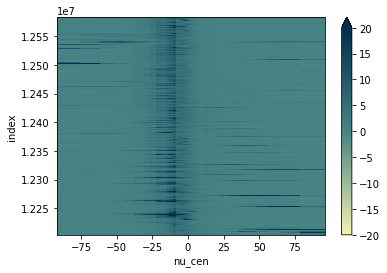

In [269]:
query = hp.query_strip(nside, np.radians(160), np.radians(180))
I_v.sel(index=query).plot(x='nu_cen', cmap='div yel grn', vmin=-20, vmax=20)

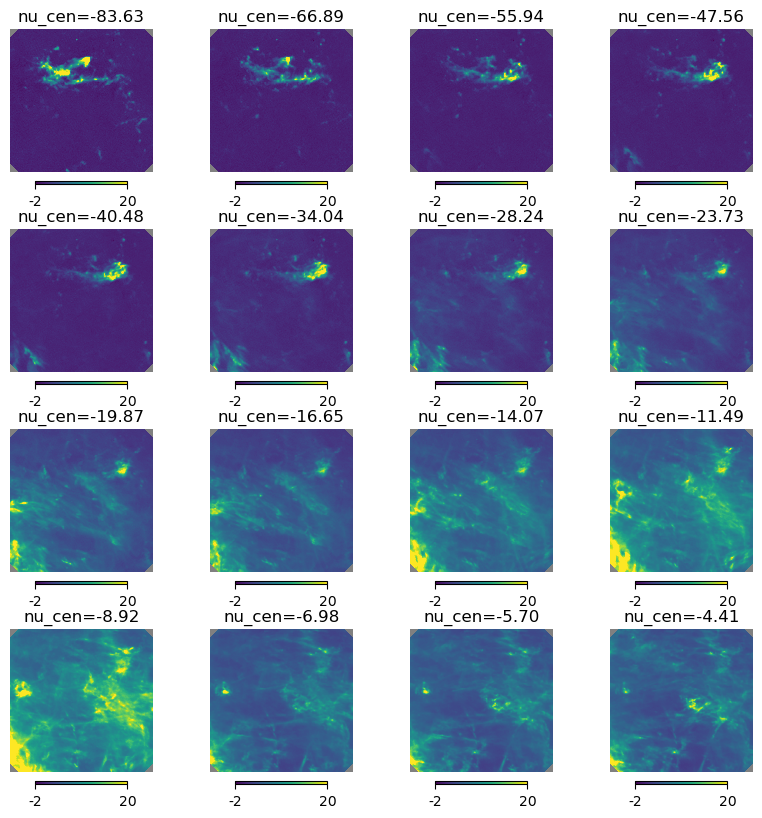

In [270]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8), dpi=100)

for i, j in enumerate(range(16)):
    axes.flatten()[i].set_axis_off()
    inspect = np.empty(npix)
    inspect.fill(hp.UNSEEN)
    inspect[query] = I_v.isel(index=query, nu_cen=j).values
    hp.azeqview(inspect, sub=(4, 4, i+1), title=f"nu_cen={I_v.nu_cen[j].values:.02f}", rot=[0, -90], xsize=1200, ysize=1200, min=-2, max=20)

In [271]:
planck_1024 = np.empty(npix)
planck_1024.fill(hp.UNSEEN)
planck_1024[query] = hp.ud_grade(planck_353_iqu[0], nside_out=1024)[query]

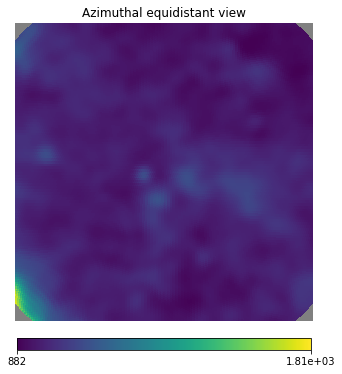

In [272]:
hp.azeqview(planck_1024, rot=[0, -90], xsize=1200, ysize=1200)

In [299]:
h1_1024 = np.empty(npix)
h1_1024.fill(hp.UNSEEN)
h1_1024[query] = hp.ud_grade(h1[0], nside_out=1024)[query]

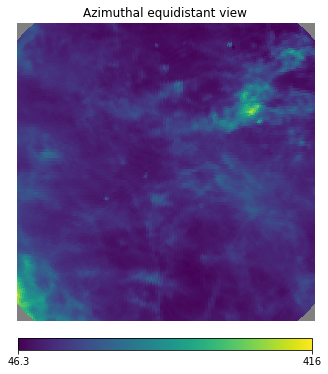

In [300]:
hp.azeqview(h1_1024, rot=[0, -90], xsize=1200, ysize=1200)

In [301]:
SkyCoord(ra="5h 23m", dec="-69 deg").galactic
SkyCoord(ra=)

<SkyCoord (Galactic): (l, b) in deg
    (279.58971762, -33.07528922)>

In [302]:
mc_idx = hp.query_disc(1024, hp.ang2vec(300.58, -80, lonlat=True), np.pi/180.*3)

In [303]:
h1_1024[mc_idx] = hp.UNSEEN

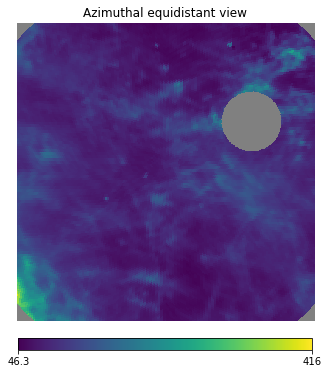

In [304]:
hp.azeqview(h1_1024, rot=[0, -90], xsize=1200, ysize=1200)

## Ideas for clustering and correlations

Identifying line of sight complexity:

* Correlation between total HI and velocity channels via:
    - Simple correlation coefficient
    - Cross power spectra
* Clustering analysis:
    - K-means clustering, including velocity information

In [41]:
display(hdu.header)

SIMPLE  =                    T                                                  
BITPIX  =                  -64                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  149                                                  
NAXIS2  =                  149                                                  
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRPIX1  =               75.907                                                  
CRVAL1  =                   0.                                                  
CDELT1  =      -0.006666666828                                                  
CTYPE1  = 'GLON-CAR'                                                            
CRPIX2  =              74.84